In [ ]:
#import packages and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_load_data 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import ClusterCentroids

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

mitbih_test = data_load_data.load_dataframe("test")
mitbih_train = data_load_data.load_dataframe("train")
ptbdb_abnormal = data_load_data.load_dataframe("abnormal")
ptbdb_normal = data_load_data.load_dataframe("normal")

#rename columns

for df in [ptbdb_abnormal, ptbdb_normal, mitbih_test, mitbih_train]:
    df.columns = [i for i in range(len(df.columns))]

#combine datasets, remove class 4, combine classes 1,2,3

ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal])
mitbih = pd.concat([mitbih_train, mitbih_test])

mitbih_recoded = mitbih.loc[mitbih[187] != 4]
mitbih_recoded.loc[:, 187] = mitbih_recoded[187].replace([1,2,3], 1)

df_total = pd.concat([mitbih_recoded, ptbdb])

#split into train and test

X = df_total.drop(187, axis=1)
y = df_total[187]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [11]:
#create and fit cluster centroids resampling

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)

In [ ]:
#build MLP model sequentially, dropout layer between each dense layer to help avoid overfitting and allow both classes to be well predicted

model = Sequential()

model.add(Dense(units=512, activation='relu', input_shape=(187,)))
model.add(Dropout(0.4))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='sigmoid'))

#compile model

model.compile(loss="binary_crossentropy", #loss function for binary classification
              optimizer="adam",
              metrics=["accuracy"])

#train model

history = model.fit(X_cc, y_cc, epochs=50, batch_size=32, validation_split=0.1)

#make prediction on test set

test_pred = model.predict(X_test) #returns array of probabilities of belonging to class 1

y_test_class = y_test
y_pred_class = (test_pred > 0.5)

print(classification_report(y_test_class, y_pred_class)) # returns boolean array, True if probability of belonging to class 1 > 0.5, False otherwise

c:\Users\maxjj\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6834 - loss: 0.5851 - val_accuracy: 0.8320 - val_loss: 0.3667
Epoch 2/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7527 - loss: 0.4984 - val_accuracy: 0.7655 - val_loss: 0.4259
Epoch 3/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7833 - loss: 0.4544 - val_accuracy: 0.6954 - val_loss: 0.5413
Epoch 4/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8073 - loss: 0.4179 - val_accuracy: 0.7476 - val_loss: 0.4785
Epoch 5/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8197 - loss: 0.3989 - val_accuracy: 0.7637 - val_loss: 0.4764
Epoch 6/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8320 - loss: 0.3762 - val_accuracy: 0.7476 - val_loss: 0.5003
Epoch 7/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8424 - loss: 0.3600 - val_accuracy: 0.8006 - val_loss: 0.4036
Epoch 8/50
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8505 - loss: 0.3452 - val_accuracy: 0.

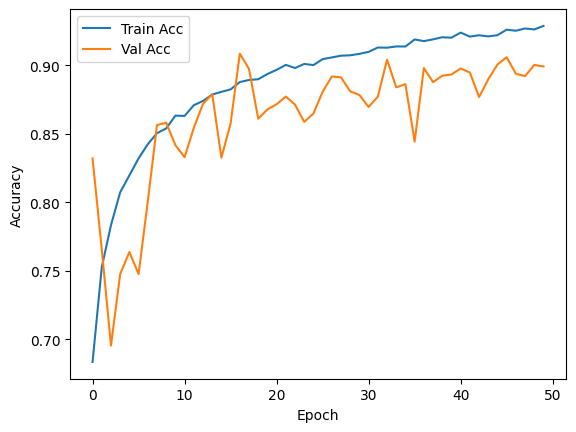

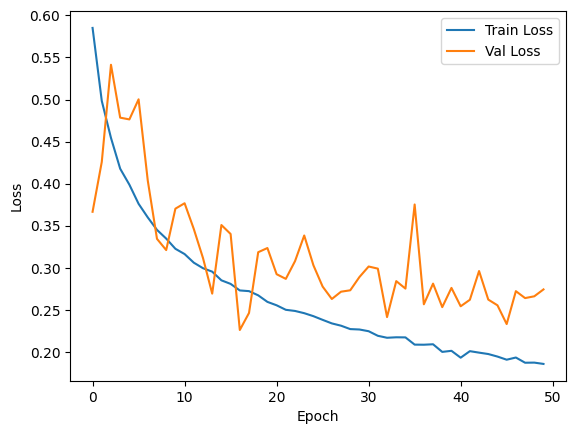

In [ ]:
#visualise loss and accuracy evolution for training and validation sets

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#evaluate on training set

model.evaluate(X_cc, y_cc)

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9545 - loss: 0.1289


[0.12886568903923035, 0.9544708132743835]

In [ ]:
#evaluate on test set

model.evaluate(X_test, y_test)

725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9580 - loss: 0.1264


[0.12640024721622467, 0.9579578042030334]

In [ ]:
#dnn performs better without resampling